## Exploratory Data Analysis
https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbkfx0.htm

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats.mstats import trimmed_var
import plotly.express as px

In [2]:
df = pd.read_csv("data/SCFP2019.csv")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


Using a mask to subset create `df` to only households that have been turned down or feared being turned down for credit `("TURNFEAR" == 1)`. Assign this subset to the variable name `df_fear`.

In [3]:
mask = df["TURNFEAR"] == 1
mask.sum()

4623

In [4]:
mask = df["TURNFEAR"] == 1
df_fear = df[mask]
print("df_fear shape:", df_fear.shape)
df_fear.head()

df_fear shape: (4623, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


Creating a list `age_groups` with the unique values in the `"AGECL"` column.

In [6]:
age_groups = df_fear["AGECL"].unique()
print("Age Groups:", age_groups)



Age Groups: [3 5 1 2 4 6]


Let's create a dictionary with `age_groups` and then visualize it.

In [7]:
agecl_dict = {
    1: "Under 35",
    2: "35-44",
    3: "45-54",
    4: "55-64",
    5: "65-74",
    6: "75 or Older",
}

age_cl = df_fear["AGECL"].replace(agecl_dict)
age_cl.head()

5    45-54
6    45-54
7    45-54
8    45-54
9    45-54
Name: AGECL, dtype: object

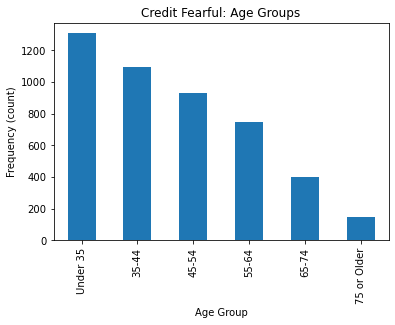

In [8]:
age_cl_value_counts = age_cl.value_counts()

# Bar plot of `age_cl_value_counts`
age_cl_value_counts.plot(
    kind = "bar",
    xlabel = "Age Group",
    ylabel = "Frequency (count)",
    title = "Credit Fearful: Age Groups"
);

### Our chart is telling us that many of the people who fear being denied credit are younger. But the first two age groups cover a wider range than the other four. So it might be useful to look inside those values to get a more granular understanding of the data.

To do that, we'll need to look at a different variable: `"AGE"`. Whereas `"AGECL"` was a categorical variable, `"AGE"` is continuous, so we can use it to make a histogram of our own.

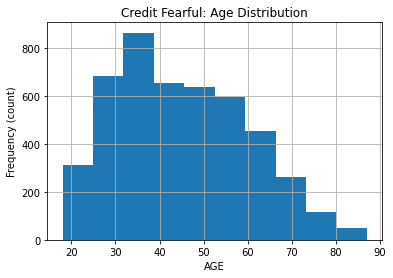

In [9]:
# Plot histogram of "AGE"
df_fear["AGE"].hist(bins=10)
plt.xlabel("AGE")
plt.ylabel("Frequency (count)")
plt.title("Credit Fearful: Age Distribution");

Now that we have an understanding of how age relates to our outcome of interest, let's try some other possibilities, starting with race. 

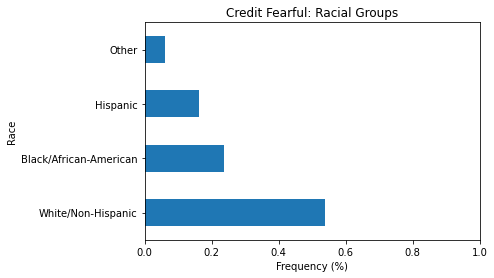

In [10]:
race_dict = {
    1: "White/Non-Hispanic",
    2: "Black/African-American",
    3: "Hispanic",
    5: "Other",
}
race = df_fear["RACE"].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)
# Create bar chart of race_value_counts
race_value_counts.plot(kind="barh")
plt.xlim((0, 1))
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("Credit Fearful: Racial Groups");

This suggests that White/Non-Hispanic people worry more about being denied credit, but thinking critically about what we're seeing, that might be because there are more White/Non-Hispanic in the population of the United States than there are other racial groups, and the sample for this survey was specifically drawn to be representative of the population as a whole. (In this case, remember that this dataset doesn't provide a complete picture of race in America. This is a sample.)

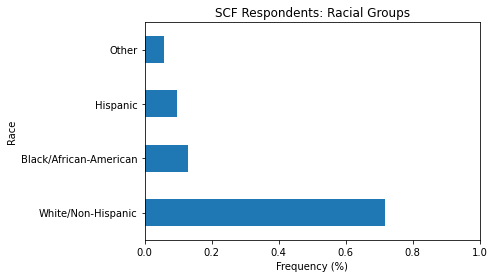

In [11]:
race = df["RACE"].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)
# Create bar chart of race_value_counts
race_value_counts.plot(kind="barh")
plt.xlim((0, 1))
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("SCF Respondents: Racial Groups");

How does this second bar chart change our perception of the first one? On the one hand, we can see that White Non-Hispanics account for around 70% of whole dataset, but only 54% of credit fearful respondents. On the other hand, Black and Hispanic respondents represent 23% of the whole dataset but 40% of credit fearful respondents. In other words, Black and Hispanic households are actually *more* likely to be in the credit fearful group. 

## Income Level
What about income level? Are people with lower incomes concerned about being denied credit, or is that something people with more money worry about? In order to answer that question, we'll need to again compare the entire dataset with our subgroup using the `"INCCAT"`(income category) feature, which captures income percentile groups. This time, though, we'll make a single, side-by-side bar chart.

In [12]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

df_inccat = (
    df["INCCAT"]
    .replace(inccat_dict)
    .groupby(df["TURNFEAR"])
    .value_counts(normalize=True)
    .rename("frequency")
    .reset_index()
)

df_inccat

,TURNFEAR,INCCAT,frequency
0,0,90-100,0.297296
1,0,60-79.9,0.174841
2,0,40-59.9,0.143146
3,0,0-20,0.140343
4,0,21-39.9,0.135933
5,0,80-89.9,0.108441
6,1,0-20,0.288125
7,1,21-39.9,0.256327
8,1,40-59.9,0.228856
9,1,60-79.9,0.132598


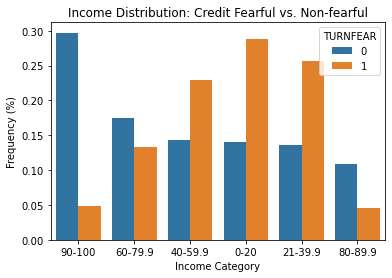

In [12]:
# Create bar chart of `df_inccat`
sns.barplot(
    x = "INCCAT",
    y = "frequency",
    hue = "TURNFEAR",
    data = df_inccat
)

plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Credit Fearful vs. Non-fearful");

Comparing the income categories across the fearful and non-fearful groups, we can see that credit fearful households are much more common in the lower income categories. In other words, the credit fearful have lower incomes.

So, based on all this, what do we know? Among the people who responded that they were indeed worried about being approved for credit after having been denied in the past five years, a plurality of the young and low-income had the highest number of respondents. That makes sense, right? Young people tend to make less money and rely more heavily on credit to get their lives off the ground, so having been denied credit makes them more anxious about the future.

### Assets
Not all the data is demographic, though. If you were working for a bank, you would probably care less about how old the people are, and more about their ability to carry more debt. If we were going to build a model for that, we'd want to establish some relationships among the variables, and making some correlation matrices is a good place to start.

In [13]:
asset_house_corr = df["ASSET"].corr(df["HOUSES"])
print("SCF: Asset Houses Correlation:", asset_house_corr)

SCF: Asset Houses Correlation: 0.5198273544779252


That's a moderate positive correlation, which we would probably expect, right? For many Americans, the value of their primary residence makes up most of the value of their total assets. What about the people in our `TURNFEAR` subset, though? Let's run that correlation to see if there's a difference.

In [14]:
asset_house_corr = df_fear["ASSET"].corr(df_fear["HOUSES"])
print("Credit Fearful: Asset Houses Correlation:", asset_house_corr)

Credit Fearful: Asset Houses Correlation: 0.5832879735979152


It's still only a moderate positive correlation, but the relationship between the total value of assets and the value of the primary residence is stronger for our `TURNFEAR` group than it is for the population as a whole.

Let's make correlation matrices using the rest of the data for both `df` and `df_fear` and see if the differences persist. Here, we'll look at only 5 features: `"ASSET"`, `"HOUSES"`, `"INCOME"`, `"DEBT"`, and `"EDUC"`.

In [15]:
cols = ["ASSET", "HOUSES", "INCOME", "DEBT", "EDUC"]
corr = df[cols].corr()
corr.style.background_gradient(axis=None)

,ASSET,HOUSES,INCOME,DEBT,EDUC
ASSET,1.000000,0.519827,0.622429,0.261250,0.116673
HOUSES,0.519827,1.000000,0.247852,0.266661,0.169300
INCOME,0.622429,0.247852,1.000000,0.114646,0.069400
DEBT,0.261250,0.266661,0.114646,1.000000,0.054179
EDUC,0.116673,0.169300,0.069400,0.054179,1.000000


In [16]:
corr = df_fear[cols].corr()
corr.style.background_gradient(axis=None)

,ASSET,HOUSES,INCOME,DEBT,EDUC
ASSET,1.000000,0.583288,0.722074,0.474658,0.113536
HOUSES,0.583288,1.000000,0.264099,0.962629,0.160348
INCOME,0.722074,0.264099,1.000000,0.172393,0.133170
DEBT,0.474658,0.962629,0.172393,1.000000,0.177386
EDUC,0.113536,0.160348,0.133170,0.177386,1.000000


There are some pretty important differences here! The relationship between `"DEBT"` and `"HOUSES"` is positive for both datasets, but while the coefficient for df is fairly weak at `0.26`, the same number for `df_fear` is `0.96`.

Remember, the closer a correlation coefficient is to 1.0, the more exactly they correspond. In this case, that means the value of the primary residence and the total debt held by the household is getting pretty close to being the same. This suggests that the main source of debt being carried by our `"TURNFEAR"` folks is their primary residence, which, again, is an intuitive finding. 


`"DEBT"` and `"ASSET"` share a similarly striking difference, as do `"EDUC"` and `"DEBT"` which, while not as extreme a contrast as the other, is still big enough to catch the interest of our hypothetical banker.

### Education
let's start with education levels `"EDUC"`, comparing credit fearful and non-credit fearful groups.

In [17]:
df_educ = (
    df["EDUC"]
    .groupby(df["TURNFEAR"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
    
)
df_educ

,TURNFEAR,EDUC,frequency
0,0,12,0.257481
1,0,8,0.192029
2,0,13,0.149823
3,0,9,0.129833
4,0,14,0.096117
5,0,10,0.051150
6,0,11,0.046492
7,0,7,0.019578
8,0,4,0.012035
9,0,6,0.011953


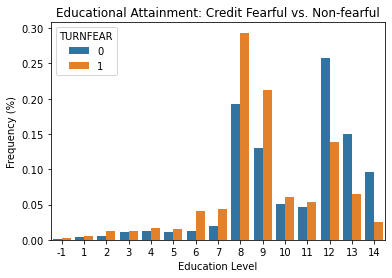

In [18]:
# Create bar chart of `df_educ`
sns.barplot(
    x = "EDUC",
    y = "frequency",
    hue = "TURNFEAR",
    data = df_educ
)

plt.xlabel("Education Level")
plt.ylabel("Frequency (%)")
plt.title("Educational Attainment: Credit Fearful vs. Non-fearful");

In this plot, we can see that a much higher proportion of credit-fearful respondents have only a high school diploma, while university degrees are more common among the non-credit fearful.

### Debt
Now we will see some scatter plots to look at debt.

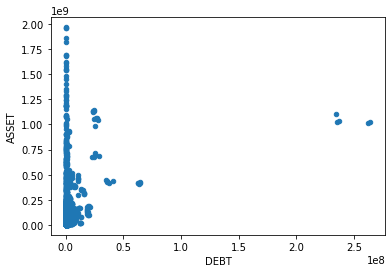

In [19]:
# Create scatter plot of ASSET vs DEBT, df
df.plot.scatter(x="DEBT", y = "ASSET");

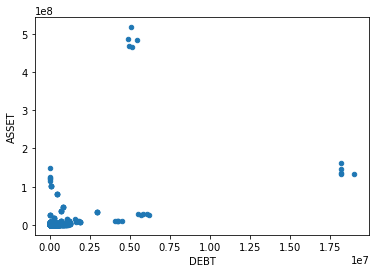

In [20]:
# Create scatter plot of ASSET vs DEBT, df_fear
df_fear.plot.scatter(x="DEBT", y = "ASSET");

You can see relationship in our `df_fear` graph is flatter than the one in our `df` graph, but they clearly are different.

Let's end with the most striking difference from our metrices, and make some scatter plots showing the difference between `HOUSES` and `DEBT`.

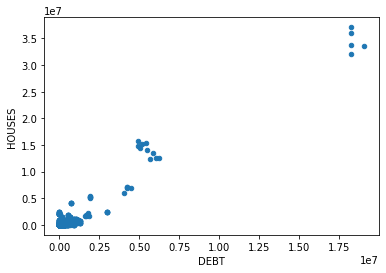

In [21]:
# Create scatter plot of HOUSES vs DEBT, df_fear
df_fear.plot.scatter(x="DEBT", y = "HOUSES");

The outliers make it a little difficult to see the difference between these two plots, but the relationship is clear enough: our `df_fear` graph shows an almost perfect linear relationship, while our `df` graph shows something a little more muddled. You might also notice that the datapoints on the `df_fear` graph form several little groups.

## Clustering

In [23]:
# Define wrangle function
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask = df["TURNFEAR"] == 1
    df = df[mask]
    return df

In [24]:
df_cluster = wrangle("data/SCFP2019.csv")
print(df_cluster.shape)
df_cluster.head()

(4623, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


We will create the feature matrix `X`. It will contain two features only: `"DEBT"` and `"HOUSES"`

In [32]:
X = df_cluster[["DEBT","HOUSES"]]
print(X.shape)
X.head()

(4623, 2)


,DEBT,HOUSES
5,12200.0,0.0
6,12600.0,0.0
7,15300.0,0.0
8,14100.0,0.0
9,15400.0,0.0


## Build Model

In [33]:
# Build model
model = KMeans(n_clusters=3, random_state = 42)
# Fit model to data
model.fit(X)

KMeans(n_clusters=3, random_state=42)

And there it is. 42 datapoints spread across three clusters. Let's grab the labels that the model has assigned to the data points so we can start making a new visualization.

In [34]:
labels = model.labels_
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Using the labels we just extracted, let's recreate the scatter plot from before, this time we'll color each point according to the cluster to which the model assigned it.

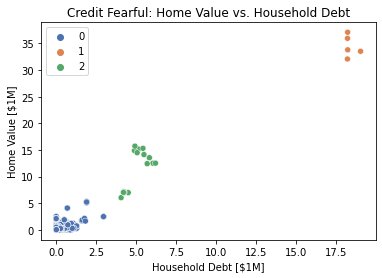

In [37]:
# Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x=df_cluster["DEBT"] / 1e6, 
    y=df_cluster["HOUSES"] / 1e6,
    hue=labels,
    palette = "deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

We can see each cluster has its own color. The centroids are still missing, so let's pull those out.

#### Centroid
A centroid is the imaginary or real location representing the center of the cluster.

In [38]:
centroids = model.cluster_centers_
centroids

array([[   91017.57766674,   116150.29328699],
       [18384100.        , 34484000.        ],
       [ 5065800.        , 11666666.66666667]])

Now we will add centroids to the grapg

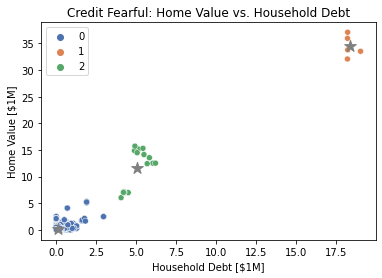

In [40]:
# Plot "HOUSES" vs "DEBT", add centroids
sns.scatterplot(
    x=df_cluster["DEBT"] / 1e6, 
    y=df_cluster["HOUSES"] / 1e6,
    hue=labels,
    palette = "deep"
)

plt.scatter(
    x=centroids[:, 0] / 1e6,
    y=centroids[:, 1] / 1e6,
    color="grey",
    marker="*",
    s=150
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

It looks great but we need to do some mathematical evaluation to check if everything is right. There are two metrics that we'll use to evaluate our clusters. We'll start with inertia, which measure the distance between the points within the same cluster

In [41]:
inertia = model.inertia_
print("Inertia (3 clusters):", inertia)

Inertia (3 clusters): 939554010797047.0


The "best" inertia is 0, and our score is pretty far from that. ertia is a measurement of distance that means the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes. And since `"DEBT"` and `"HOUSES"` are measured in tens of millions of dollars, it's not surprising that inertia is so large.

However, we have a metric that is easier to interpret, and that's where `silhouette score` comes in. Silhouette score measures the distance between different clusters. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than `inertia`.

In [44]:
ss = silhouette_score(X, model.labels_)
print("Silhouette Score (3 clusters):", ss)

Silhouette Score (3 clusters): 0.9768842462944348


0.977 is pretty close to 1, so our model has done a good job at identifying 3 clusters that are far away from each other.

It's important to remember that these performance metrics are the result of the number of clusters we told our model to create. In unsupervised learning, the number of clusters is hyperparameter that you set before training your model. Let's see what happens when we change our cluster size.

In [45]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    #Build model
    model = KMeans(n_clusters=k, random_state=42)
    #Train Model
    model.fit(X)
    #Calculate inertia
    inertia_errors.append(model.inertia_)
    #Calculate ss
    silhouette_scores.append(silhouette_score(X, model.labels_))

print("Inertia:", inertia_errors)
print()
print("Silhouette Scores:", silhouette_scores)

Inertia: [3018038313336915.5, 939554010797047.0, 546098841715653.7, 309310386410919.4, 235243397481788.66, 182225729179699.6, 150670779013794.94, 114321995931020.7, 100340259483916.8, 86229997033602.34, 74757234072100.34]

Silhouette Scores: [0.9855099957519555, 0.9768842462944348, 0.9490311483406091, 0.839330043242819, 0.7287406719898627, 0.726989114305748, 0.7263840026889208, 0.7335125606476427, 0.692157992955073, 0.6949309528556856, 0.6951831031001252]


Now that we have both performance metrics for several different settings of `n_clusters`, now we will make some line plots to see the relationship between the number of clusters in a model and its `inertia` and `silhouette scores`.

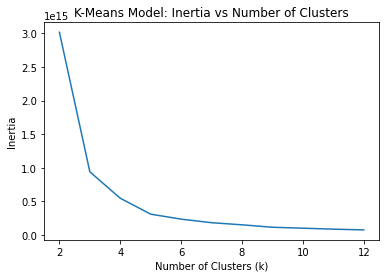

In [46]:
# Plot `inertia_errors` by `n_clusters`
plt.plot(n_clusters, inertia_errors)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Model: Inertia vs Number of Clusters");

The trick with choosing the right number of clusters is to look for the "bend in the elbow" for this plot. In other words, we want to pick the point where the drop in inertia becomes less dramatic and the line begins to flatten out. In this case, it looks like the sweet spot is 4 o


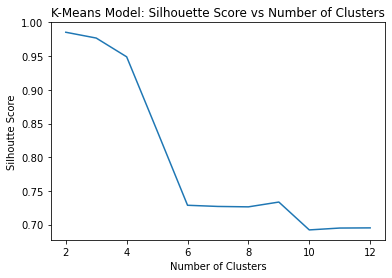

In [47]:
# Plot `silhouette_scores` vs `n_clusters`
plt.plot(n_clusters, silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.title("K-Means Model: Silhouette Score vs Number of Clusters");

In contrast to our inertia plot, bigger is better. So we're not looking for a "bend in the elbow" but rather a number of clusters for which the silhouette score still remains high. We can see that silhouette score drops drastically beyond 4 clusters. Given this and what we saw in the inertia plot, it looks like the optimal number of clusters is 4

In [48]:
# Build model
final_model = KMeans(n_clusters=4, random_state=42)
# Fit model to data
final_model.fit(X)

KMeans(n_clusters=4, random_state=42)

In [49]:
final_model.algorithm

'auto'

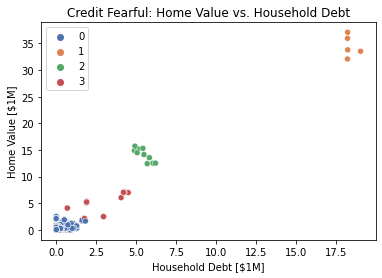

In [51]:
# Plot "HOUSES" vs "DEBT" with final_model labels
sns.scatterplot(
    x=df_cluster["DEBT"] / 1e6,
    y=df_cluster["HOUSES"] / 1e6,
    hue = final_model.labels_,
    palette = "deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

We can see all four of our clusters, each differentiated from the rest by color. We're going to make one more visualization, converting the cluster analysis we just did to something a little more actionable: a side-by-side bar chart. In order to do that, we need to put our clustered data into a DataFrame.

In [52]:
xgb = X.groupby(final_model.labels_).mean()
xgb

,DEBT,HOUSES
0,8.488629e+04,1.031872e+05
1,1.838410e+07,3.448400e+07
2,5.472800e+06,1.407400e+07
3,2.420929e+06,4.551429e+06


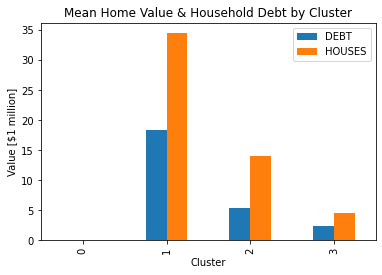

In [53]:
# Create side-by-side bar chart of `xgb`
(xgb / 1e6).plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Value [$1 million]")
plt.title("Mean Home Value & Household Debt by Cluster");

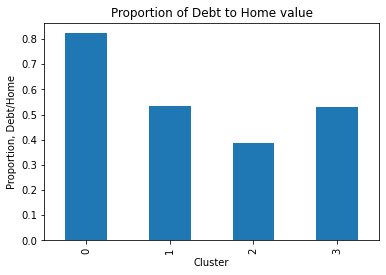

In [54]:
(xgb["DEBT"] / xgb["HOUSES"]).plot(
    kind="bar",
    xlabel="Cluster",
    ylabel="Proportion, Debt/Home",
    title = "Proportion of Debt to Home value"
);

In this plot, we have our four clusters spread across the x-axis, and the dollar amounts for home value and household debt on the y-axis.

The first thing to look at in this chart is the different mean home values for the five clusters. Clusters 0 represents households with small to moderate home values, clusters 2 and 3 have high home values, and cluster 1 has extremely high values.

The second thing to look at is the proportion of debt to home value. In clusters 1 and 3, this proportion is around 0.5. This suggests that these groups have a moderate amount of untapped equity in their homes. But for group 0, it's almost 1, which suggests that the largest source of household debt is their mortgage. Group 2 is unique in that they have the smallest proportion of debt to home value, around 0.4.

This information could be useful to financial institution that want to target customers with products that would appeal to them.

## Clustering with Multiple Features

In [56]:
def wrangle(filepath):
    # Read file into DataFrame
    df = pd.read_csv(filepath)
    mask = (df["TURNFEAR"] == 1) & (df["NETWORTH"] < 2e6)
    return df

In [64]:
df_mclusters = wrangle("data/SCFP2019.csv")
print(df_mclusters.shape)
df_mclusters.head()

(28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


In [65]:
# Calculate variance, get 10 largest features
top_ten_var = df_mclusters.var().sort_values().tail(10)
top_ten_var

EQUITY      5.674332e+14
FIN         1.054968e+15
ACTBUS      2.246149e+15
KGBUS       2.398037e+15
KGTOTAL     2.805429e+15
BUS         3.184224e+15
NHNFIN      3.606887e+15
NFIN        3.764771e+15
NETWORTH    6.142046e+15
ASSET       6.275796e+15
dtype: float64

It's harder to make sense of a list like this than it would be if we visualized it, so let's make a graph.

In [66]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    title="SCF: High Variance Features"
)

fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
fig.show()

In [67]:
# Create a boxplot of `NHNFIN`
fig = px.box(
    data_frame = df_mclusters,
    x="NHNFIN",
    title="Distribution of Non-home, Non-Financial Assets"
)
fig.update_layout(xaxis_title="Value [$]")
fig.show()

The dataset is massively right-skewed because of the huge outliers on the right side of the distribution. Even though we already excluded households with a high net worth with our `wrangle` function, the variance is still being distorted by some extreme outliers.
The best way to deal with this is to look at the trimmed variance, where we remove extreme values before calculating variance. We can do this using the `trimmed_variance` function from the `SciPy` library.

In [68]:
df_mclusters["DEBT"].var()

12480480690861.83

In [70]:
# Calculate trimmed variance
top_ten_trim_var = df_mclusters.apply(trimmed_var,limits=(0.1,0.1)).sort_values().tail(10)
top_ten_trim_var

ACTBUS      7.155756e+10
HOUSES      1.023246e+11
BUS         2.388293e+11
EQUITY      2.649854e+11
KGTOTAL     5.164773e+11
NHNFIN      8.678274e+11
FIN         1.085358e+12
NFIN        1.818981e+12
NETWORTH    7.623697e+12
ASSET       8.309529e+12
dtype: float64

In [71]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title = "SCF: High Variance Features"
)

fig.update_layout(xaxis_title="Trimmed Variance", yaxis_title="Feature")

fig.show()

In [73]:
# Columns with high variance
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['NHNFIN', 'FIN', 'NFIN', 'NETWORTH', 'ASSET']

Now that we've gotten our data to a place where we can use it, we can follow the steps we've used before to build a model, starting with a feature matrix.

In [74]:
X = df_mclusters[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (28885, 5)


,NHNFIN,FIN,NFIN,NETWORTH,ASSET
0,44600.0,1009000,1144600.0,2153600.0,2153600.0
1,38200.0,978000,1138200.0,2116200.0,2116200.0
2,34000.0,1011000,1134000.0,2145000.0,2145000.0
3,38500.0,1414000,1138500.0,2552500.0,2552500.0
4,44200.0,1032000,1144200.0,2176200.0,2176200.0


During our EDA, we saw that we had a scale issue among our features. That issue can make it harder to cluster the data, so we'll need to fix that to help our analysis along. One strategy we can use is standardization, a statistical method for putting all the variables in a dataset on the same scale. Let's explore how that works here. Later, we'll incorporate it into our model pipeline.

In [75]:
X.mean()

NHNFIN      8.262630e+06
FIN         4.769832e+06
NFIN        8.987195e+06
NETWORTH    1.345840e+07
ASSET       1.375703e+07
dtype: float64

In [76]:
X_summary = X.aggregate(["mean","std"]).astype("int")
X_summary

,NHNFIN,FIN,NFIN,NETWORTH,ASSET
mean,8262629,4769831,8987194,13458400,13757026
std,60057361,32480270,61357727,78371209,79219920


That's the information we need to standardize our data, so now we will use `StandardScaler` for standardization.

In [77]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns)

#print("X_scaled shape:", X_scaled.shape)
X_scaled.head()

,NHNFIN,FIN,NFIN,NETWORTH,ASSET
0,-0.136839,-0.115790,-0.127820,-0.144249,-0.146474
1,-0.136945,-0.116745,-0.127924,-0.144727,-0.146946
2,-0.137015,-0.115729,-0.127993,-0.144359,-0.146582
3,-0.136940,-0.103321,-0.127919,-0.139159,-0.141438
4,-0.136845,-0.115082,-0.127826,-0.143961,-0.146188


As we can see, all five of the features use the same scale now. But just to make sure, let's take a look at their mean and standard deviation.

In [78]:
X_scaled_summary = X_scaled.aggregate(["mean","std"]).astype(int)
X_scaled_summary

,NHNFIN,FIN,NFIN,NETWORTH,ASSET
mean,0,0,0,0,0
std,1,1,1,1,1


And that's what it should look like. Standardization takes all the features and scales them so that they all have a mean of 0 and a standard deviation of 1.

Now that we can compare all our data on the same scale, we can start making clusters. Just like we did last time, we need to figure out how many clusters we should have.

In [79]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # Build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    # Train Model
    model.fit(X)
    # Calculate inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate Silhouette Score
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )
print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [57065.95983103709, 40595.74221588281, 27956.297156085726]

Silhouette Scores: [0.9772061148942238, 0.9620295163078645, 0.9416311915345549]


Just like last time, let's create an elbow plot to see how many clusters we should use.

In [80]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters (k)", yaxis_title="Inertia")
fig.show()

We can see that the line starts to flatten out around 4 or 5 clusters.

In [81]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=silhouette_scores,
    title="K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(
    xaxis_title="Number of Clusters (k)", yaxis_title="Silhouette Score"
)
fig.show()

This one's a little less straightforward, but we can see that the best silhouette scores occur when there are 3 or 4 clusters.

Putting the information from this plot together with our inertia plot, it seems like the best setting for `n_clusters` will be 4.

In [82]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=4,random_state=42),
    
)
final_model.fit(X)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

## Communicate Result

In [83]:
labels = final_model.named_steps["kmeans"].labels_
print(labels[:5])

[0 0 0 0 0]


In [84]:
xgb = X.groupby(labels).mean()
xgb

,NHNFIN,FIN,NFIN,NETWORTH,ASSET
0,2.258882e+06,2.136091e+06,2.794431e+06,4.736792e+06,4.930521e+06
1,8.331564e+08,1.024548e+08,8.513295e+08,9.383494e+08,9.537844e+08
2,1.393855e+08,8.548359e+07,1.458356e+08,2.286599e+08,2.313192e+08
3,3.513339e+08,9.284707e+08,3.621433e+08,1.290467e+09,1.290614e+09


Now that we have a DataFrame, let's make a bar chart and see how our clusters differ.

In [85]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Mean Household Finances by Cluster"
)

fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")
fig.show()

Remember that our clusters are based partially on `NETWORTH`, which means that the households in the 0 cluster have the smallest net worth, and the households in the 2 cluster have the highest. Based on that, there are some interesting things to unpack here.

First, take a look at the `DEBT` variable. You might think that it would scale as net worth increases, but it doesn't. The lowest amount of debt is carried by the households in cluster 2, even though the value of their houses (shown in green) is roughly the same. You can't really tell from this data what's going on, but one possibility might be that the people in cluster 2 have enough money to pay down their debts, but not quite enough money to leverage what they have into additional debts. The people in cluster 3, by contrast, might not need to worry about carrying debt because their net worth is so high.

Finally, since we started out this project looking at home values, take a look at the relationship between `DEBT` and `HOUSES`. The value of the debt for the people in cluster 0 is higher than the value of their houses, suggesting that most of the debt being carried by those people is tied up in their mortgages — if they own a home at all. Contrast that with the other three clusters: the value of everyone else's debt is lower than the value of their homes.

Since we're working with a computer screen, we don't have much of a choice about the number of dimensions we can use: it's got to be two. So, if we're going to do anything like the scatter plot we made before, we'll need to take our 5-dimensional data and change it into something we can look at in 2 dimensions. That's where dimensionality reduction come into action.

In [86]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1","PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (28885, 2)


,PC1,PC2
0,-2.010559e+07,-1.068289e+06
1,-2.015729e+07,-1.102455e+06
2,-2.012383e+07,-1.061667e+06
3,-1.960592e+07,-5.859475e+05
4,-2.007732e+07,-1.040875e+06


So there we go: our five dimensions have been reduced to two. Let's make a scatter plot and see what we get.

In [87]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame = X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()

One limitation of this plot is that it's hard to explain what the axes here represent. In fact, both of them are a combination of the five features we originally had in X, which means this is pretty abstract. Still, it's the best way we have to show as much information as possible as an explanatory tool for people.

So what does this graph mean? It means that we made four tightly-grouped clusters that share some key features. If we were presenting this to a group of stakeholders, it might be useful to show this graph first as a kind of warm-up, since most people understand how a two-dimensional object works. Then we could move on to a more nuanced analysis of the data.